# Clasificación de Reseñas de Películas en Film Junky Union

# Contenido <a id='back'></a>

* [Introducción](#intro)
* [Objetivos](#obj)
* [Etapa 1. Descripción de los datos](#data_review)
* [Etapa 2. Preprocesamiento de datos](#data_preprocessing)
* [Etapa 3. Desarrollo de modelos](#modelo)
* [Conclusiones](#end)

## Introducción <a id='intro'></a>
Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. 

## Objetivos: <a id='obj'></a>
El objetivo principal es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizaremos un conjunto de datos de reseñas de películas de IMDB con etiquetado para construir un modelo que clasifique las reseñas como positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Etapas:
El proyecto consistirá en tres etapas:
 1. Descripción de los datos.
 2. Preprocesamiento de datos.
 3. Desarrollo de modelos.


## Etapa 1. Descripción de los datos <a id='data_review'></a>

Los datos se almacenan en el archivo imdb_reviews.tsv . Aquí se describen los campos seleccionados:

* review : el texto de la reseña
* pos : el objetivo, '0' para negativo y '1' para positivo
* ds_part : 'entrenamiento'/'prueba' para

Hay otros campos en el conjunto de datos, puedes explorarlos si lo deseas.

In [89]:
# Importamos librerias necesarias
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import re
import nltk
import spacy

from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADRI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADRI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Cargamos el dataset
df = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

In [9]:
df.sample(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
21150,tt0246765,movie,Lumumba,Lumumba,2000,\N,115,0,"Biography,Drama,History",7.2,1754.0,To answer the question of a previous reviewer ...,9,pos,1,test,8593
19563,tt0295369,video,Killjoy 2: Deliverance from Evil,Killjoy 2: Deliverance from Evil,2002,\N,77,0,"Fantasy,Horror",3.1,864.0,I am sorry but this is the worst film I have e...,1,neg,0,test,4364
3092,tt0112393,movie,Art for Teachers of Children,Art for Teachers of Children,1995,\N,82,0,"Biography,Drama,Romance",6.2,81.0,"Jennifer Montgomery's ""Art for Teachers of Chi...",10,pos,1,test,718
11198,tt0393597,movie,Earth,Earth,2007,\N,90,0,Documentary,8.0,14099.0,In celebration of Earth Day Disney has release...,8,pos,1,train,1420
19416,tt0366043,tvSeries,Kerching!,Kerching!,2003,2006,\N,0,"Comedy,Family",6.1,182.0,I've noticed that a lot of people who post on ...,8,pos,1,train,5784
25236,tt0120776,movie,One True Thing,One True Thing,1998,\N,127,0,Drama,7.0,11082.0,I wonder sometimes if maybe Meryl Streep has b...,7,pos,1,test,7091
9125,tt0273517,movie,Darkness,Darkness,2002,\N,88,0,Horror,5.5,18536.0,"If you saw the grudge, a another mediocre ghos...",1,neg,0,test,7358
45410,tt0043117,movie,Wagon Master,Wagon Master,1950,\N,86,0,"Adventure,Western",7.1,4100.0,Wagon Master is a very unique film amongst Joh...,9,pos,1,test,3139
10576,tt0069994,movie,Don't Look in the Basement,The Forgotten,1973,\N,89,0,"Horror,Thriller",5.1,2784.0,Low-budget but memorable would-be shocker that...,7,pos,1,test,751
15447,tt0089243,movie,Gymkata,Gymkata,1985,\N,90,0,"Action,Thriller",4.4,3675.0,Gymkata is without a doubt one of the worst mo...,1,neg,0,train,6142


In [18]:
df.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [38]:
df['average_rating'] = df['average_rating'].fillna(df['average_rating'].mean())
df['votes'] = df['votes'].fillna(df['votes'].median())
df['votes'] = df['votes'].astype('int64')
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47331 non-null  float64
 10  votes            47331 non-null  int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(1

## Etapa 2. Preprocesamiento de datos <a id='data_preprocessing)'>

## Exploracion Inicial de Datos

In [11]:
# Analizamos el desequilibrio de clases
df_reviews['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

In [15]:
# Calculamos el desequilibrio de clases
df_reviews['pos'].value_counts(normalize=True)

pos
0    0.501046
1    0.498954
Name: proportion, dtype: float64

El conjunto de datos presenta un ligero desequilibrio de clases, la diferencia entre las clases es mínima favoreciendo a las reseñas positivas por aproximadamente 1%.

## Etapa 3. Desarrollo de modelos <a id='modelo'></a>

In [90]:
# Procedimiento de evaluacion
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

In [67]:
# Definimos una función de normalización
nlp = spacy.load('en_core_web_sm', disable=['parser','ner'])

def normalize(text):
    pattern = r"[^a-zA-z']"
    text = re.sub(pattern, " ", text)
    text = text.split()
    text = ' '.join(text)

    doc = nlp(text.lower())
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
    return ' '.join(lemmas)

In [68]:
# Aplicamos las funciones de normalizacion al DataFrame
df_reviews['review_norm'] = df_reviews['review'].apply(normalize)

print(df_reviews[['review', 'review_norm']].head())

                                              review  \
0  The pakage implies that Warren Beatty and Gold...   
1  How the hell did they get this made?! Presenti...   
2  There is no real story the film seems more lik...   
3  Um .... a serious film about troubled teens in...   
4  I'm totally agree with GarryJohal from Singapo...   

                                         review_norm  
0  the pakage imply that warren beatty and goldie...  
1  how the hell do they get this make present its...  
2  there be no real story the film seem more like...  
3  um a serious film about troubled teen in singa...  
4  I be totally agree with garryjohal from singap...  


In [70]:
# Separamos los datos de entrenamiento y test
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

In [75]:
# Costruimos la TF-IDF
stop_words = list(nltk_stopwords.words('english'))
vectorizer = TfidfVectorizer(stop_words=stop_words)
X_train = vectorizer.fit_transform(df_reviews_train['review_norm'])
X_test = vectorizer.transform(df_reviews_test['review_norm'])

           train  test
Exactitud    NaN   NaN
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


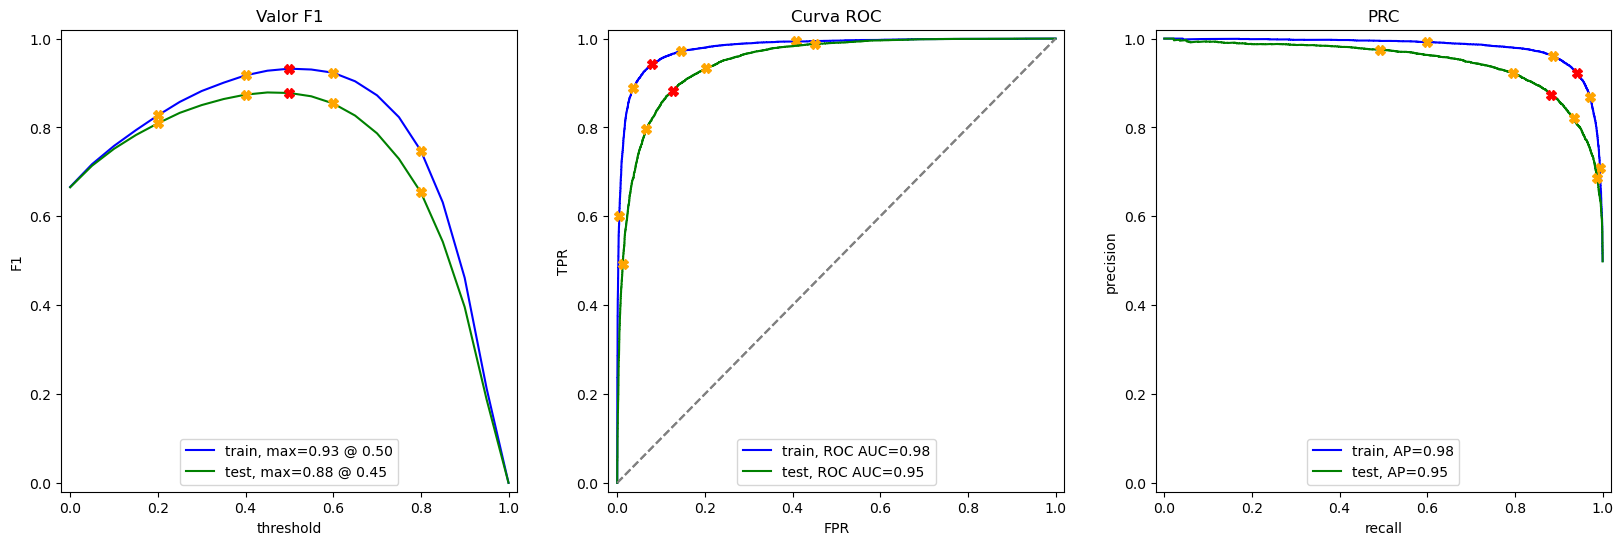

In [91]:
# Creamos el modelo de Regresion Logistica
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, train_target)
y_pred_log_reg = log_reg.predict(X_test)

evaluate_model(log_reg, X_train, train_target, X_test, test_target)

           train  test
Exactitud    NaN   NaN
F1          0.84  0.82
APS         0.91  0.89
ROC AUC     0.91  0.90


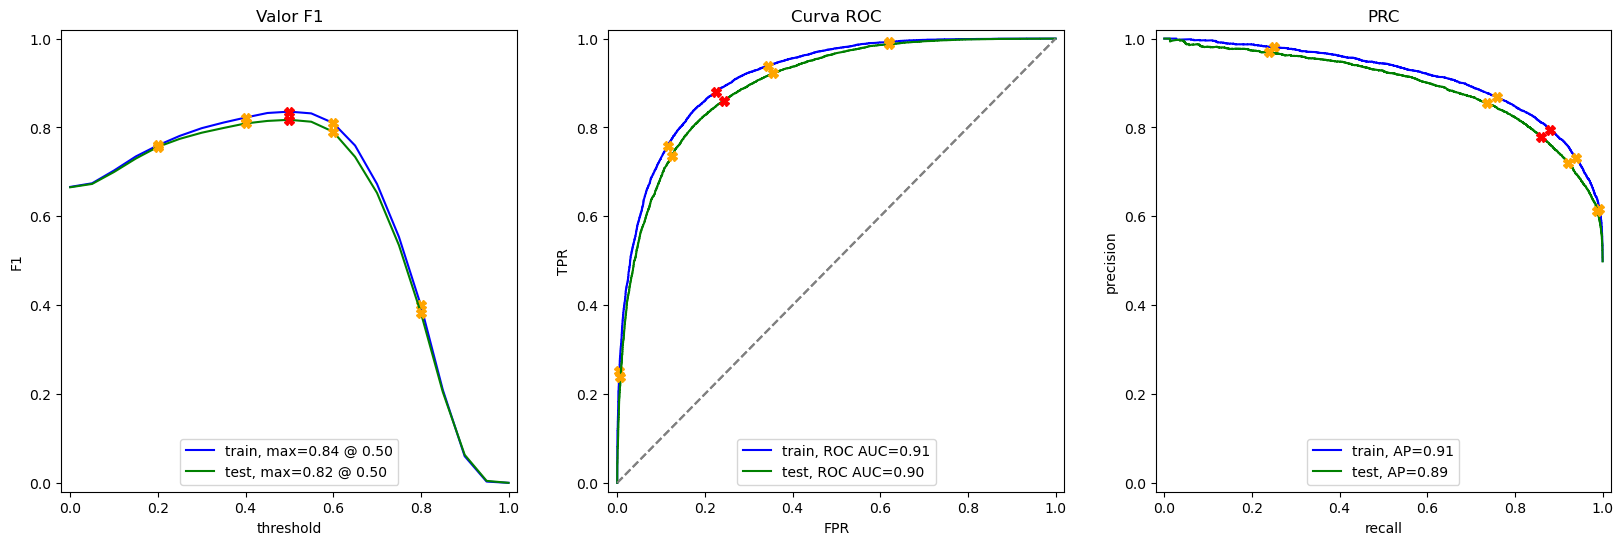

In [84]:
# Creamos el modelo de Potenciacion de Gradiente
gbc = GradientBoostingClassifier(n_estimators=100)
gbc.fit(X_train, train_target)
y_pred_gbc = gbc.predict(X_test)

evaluate_model(gbc, X_train, train_target, X_test, test_target)

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.237692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 455505
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9360
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
           train  test
Exactitud   0.91  0.86
F1          0.91  0.86
APS         0.97  0.93
ROC AUC     0.97  0.94


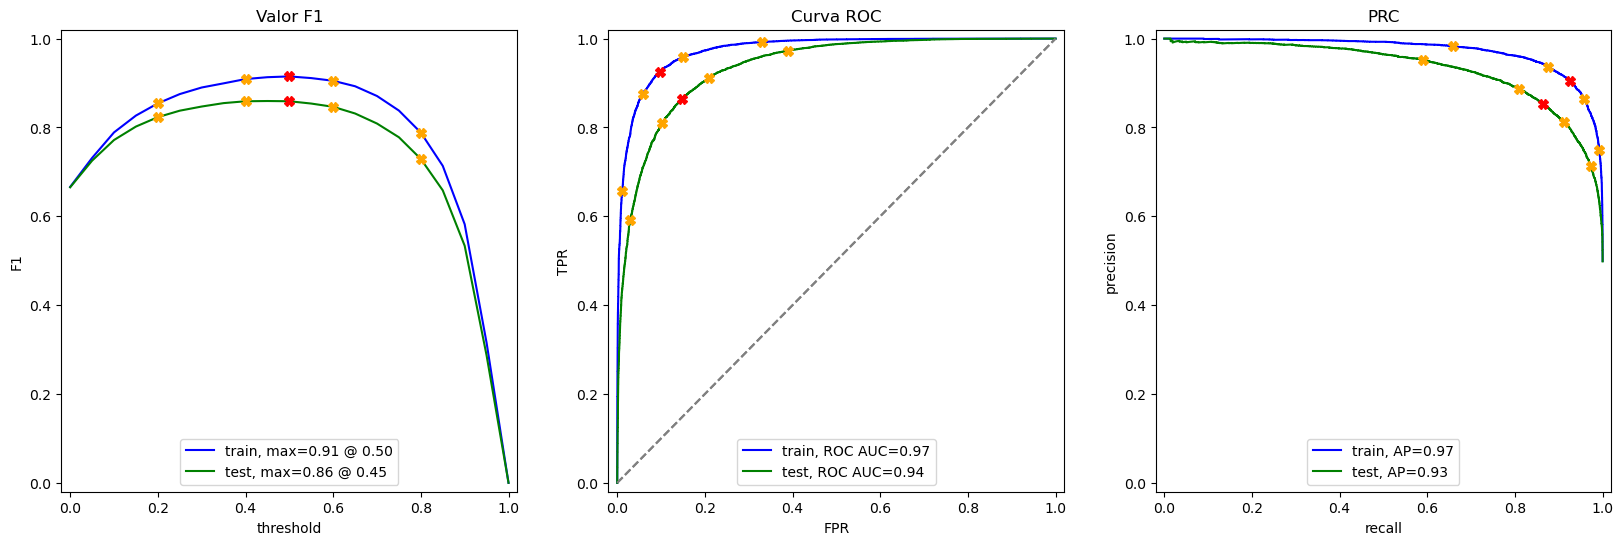

In [87]:
# Creamos el modelo de LGBMClassifier
lgbm = LGBMClassifier(n_estimators=100)
lgbm.fit(X_train, train_target)
y_pred_lgbm = lgbm.predict(X_test)

evaluate_model(lgbm, X_train, train_target, X_test, test_target)

- El modelo de Regresión Logística tiene el mejor rendimiento general en términos de F1-score, APS y ROC AUC.
- LGBMClassifier sigue de cerca, con un rendimiento ligeramente inferior.
- Gradient Boosting muestra un rendimiento aceptable, pero no tan bueno como los otros dos modelos.

In [79]:
# Agregamos unas reseñas para probar en el mejor modelo
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",I do not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well I be bored and feel asleep in the middle ...
2,I was really fascinated with the movie,I be really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actor look really old and disinterest...
4,I didn't expect the reboot to be so good! Writ...,I do not expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie have its upside and downside but I f...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launch on netflix be a brave move I really app...


In [80]:
# Probamos las nuevas predicciones en el mejor modelo
texts = my_reviews['review_norm']
vectorizer_new = TfidfVectorizer(stop_words=stop_words)
vectorizer_new.fit(df_reviews_train['review_norm'])
my_reviews_vec = vectorizer_new.transform(texts)

my_reviews_pred_prob = log_reg.predict_proba(my_reviews_vec)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  I do not simply like it not my kind of movie
0.14:  well I be bored and feel asleep in the middle of the movie
0.49:  I be really fascinated with the movie
0.10:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.27:  I do not expect the reboot to be so good writer really care about the source material
0.50:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.03:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.92:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


## Conclusion <a id='end'></a>

- La Regresión Logística demostró ser el modelo más efectivo, con un F1-score de 0.88 en el conjunto de prueba y altos valores de ROC AUC (0.95) y APS (0.95).

- El modelo LGBMClassifier también mostró buen rendimiento, con un F1-score de 0.86 en prueba y un ROC AUC de 0.94, aunque ligeramente inferior a la Regresión Logística.

- El modelo Gradient Boosting tuvo el menor rendimiento, con un F1-score de 0.82 en prueba y un ROC AUC de 0.90, pero sigue siendo una opción viable.